<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/misc/data_cleaning_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

# BUILDING FLOOR RECOGNITION

Inspired by https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/audio_classifier_tutorial.ipynb

# Table of Contents

>[BUILDING FLOOR RECOGNITION](#scrollTo=SsIKuyArEu5c)

>[Table of Contents](#scrollTo=4sAfyFF7dWGm)

>[setup](#scrollTo=nogA7rji8GbZ)

>[utils](#scrollTo=1o3-BVUy8-sF)

>[Data](#scrollTo=pk-sYaYF7U9Y)

>>[Clean Data source](#scrollTo=uHL0auVWCnL6)

>>[sample audio](#scrollTo=w9GlJyvB2SoK)



In [78]:
# https://stats.stackexchange.com/questions/559009/why-convert-spectrogram-to-rgb-for-machine-learning

same buildings recording shall not be distributed between train and test sets


Remember:

* Train with more data
* Data Augmentation
* adding noise to the input and ouput data
* feature selection
* cross-validation
* simplify data
* regularization
* ensembling
* early stopping
* adding dropout layers


# setup

In [79]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.autograd import Variable
from torch import nn

print(torch.__version__)
print(torchaudio.__version__)

1.12.1+cu113
0.12.1+cu113


In [80]:
import random 
import os
from copy import deepcopy
from tqdm import tqdm

In [81]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [82]:
from IPython.display import Audio, display
from typing import Dict,Any

In [83]:
import librosa


In [84]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)

In [85]:
seed_all(496)

In [86]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
# show current directory
!pwd

/content


# utils

In [88]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [89]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [90]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [91]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [92]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [93]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Data 

## Clean Data source

In [94]:
!rm -r Data

In [95]:
!rm -r F_MP3_3
!rm F_MP3_3.zip
!wget https://aptikal.imag.fr/~amini/F_MP3_3.zip
!unzip -qq -o F_MP3_3.zip 
!rm F_MP3_3.zip

rm: cannot remove 'F_MP3_3': No such file or directory
rm: cannot remove 'F_MP3_3.zip': No such file or directory
--2022-09-08 14:14:04--  https://aptikal.imag.fr/~amini/F_MP3_3.zip
Resolving aptikal.imag.fr (aptikal.imag.fr)... 129.88.12.12, 2001:660:5301:61::12:12
Connecting to aptikal.imag.fr (aptikal.imag.fr)|129.88.12.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36882170 (35M) [application/zip]
Saving to: ‘F_MP3_3.zip’

F_MP3_3.zip         100%[===================>]  35.17M  12.1MB/s    in 2.9s    

2022-09-08 14:14:07 (12.1 MB/s) - ‘F_MP3_3.zip’ saved [36882170/36882170]



In [96]:
# !wget http://aptikal.imag.fr/~amini/R+3.tar.bz2
# !tar xvf R+3.tar.bz2
# !rm R+3.tar.bz2

In [97]:
!rm -r R+3
!mkdir R+3
for root,dirs,file in os.walk("F_MP3_3"):
  for f in file:
    if f[0]!='.':
      dirname = f.split(".")[0][11:]
      os.mkdir(f"R+3/{dirname}")
      os.rename(f"F_MP3_3/{f}",f"R+3/{dirname}/{f}")
!rm -r F_MP3_3

rm: cannot remove 'R+3': No such file or directory


In [98]:
# Unzip dataset
!wget https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data.zip 
!unzip -o -qqq Data.zip
!rm Data.zip
!unzip -o -qqq Data/R+1.zip
!rm Data/R+1.zip
!unzip -o -qqq Data/R+5.zip 
!rm  -r Data/R+5.zip
!rm -r Data

--2022-09-08 14:14:09--  https://huggingface.co/datasets/nprime496/building_floor_classification/resolve/main/Data.zip
Resolving huggingface.co (huggingface.co)... 52.6.16.131, 52.202.207.64, 2600:1f18:147f:e800:afa4:a769:1b42:e343, ...
Connecting to huggingface.co (huggingface.co)|52.6.16.131|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/a4e8276694ca799f0dae933e3a53843a6de3602462a12a0dfb737e8e265f5e13?response-content-disposition=attachment%3B%20filename%3D%22Data.zip%22 [following]
--2022-09-08 14:14:09--  https://cdn-lfs.huggingface.co/repos/78/35/78359706ef83d9c274d488be5a74dbc0b37e4b1d8ac800dbc6203b532a392ac0/a4e8276694ca799f0dae933e3a53843a6de3602462a12a0dfb737e8e265f5e13?response-content-disposition=attachment%3B%20filename%3D%22Data.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.84.162.46, 52.84.162.75, 52.84.162.32

In [99]:
from glob import glob 
import re

# This piece of code divide folders having multiple wav samples as another batiment samples

# os.chdir("/content/")
# for floor in [1,3,5]:
#   cur_dir=f"R+{floor}"
#   for (root,dirs,files) in os.walk(cur_dir):
#     for dir in dirs:
#       cur_bat = os.path.join(root,dir)
#       os.chdir(cur_bat)
#       if len(glob("*.wav"))==2:
#         os.chdir("/content/")
#         try:
#           os.mkdir(cur_bat+"_2")
#         except:
#           pass
#         all_files = glob(os.path.join(cur_bat,"*"+dir.split("_")[0]+"*_2*"))
#         _ = [os.rename(os.path.join(f) ,os.path.join(cur_bat+"_2",f.split("/")[-1])) for f in all_files]
#         os.rename(cur_bat,cur_bat+"_1")
#       os.chdir("/content/")
#     break

In [100]:
# Remove unused files 
os.chdir("/content/")
for floor in [1,3,5]:
  cur_dir=f"R+{floor}"
  for (root,dirs,files) in os.walk(cur_dir):
    [os.remove(os.path.join(root,f)) for f in files if (not (f.endswith(".mp3")) or f[0]=='.')]

In [101]:
# Store files in new folder Data
!mkdir Data
!mv R+1 Data/R+1
!mv R+5 Data/R+5
!mv R+3 Data/R+3

In [103]:
#!zip Data_mp3_all.zip -r Data

In [108]:
from pydub import AudioSegment 
from pydub.utils import make_chunks
import os

def process_sudio(file_name,chunk_length_ms):
    myaudio = AudioSegment.from_mp3(file_name) 
    #chunk_length_ms = 5000 # pydub calculates in millisec 
    chunks = make_chunks(myaudio,chunk_length_ms) #Make chunks of chunk_length_ms/1000 sec 
    # print(len(chunks[5]))
    for i, chunk in enumerate(chunks):
        if len(chunk)==(chunk_length_ms):
          chunk_name = './' + file_name + "_{0}.wav".format(i) 
          #print ("exporting", chunk_name) 
          chunk.export(chunk_name, format="wav") 


In [109]:
# split files 
os.chdir("/content/Data")
for floor in tqdm([1,3,5]):
  cur_dir=os.path.join(f"R+{floor}")
  for (root,dirs,files) in os.walk(cur_dir):
    for f in files:
      try:
        if f.endswith(".mp3"):
          process_sudio(os.path.join(root,f),5000)
          #d["samples"].append(os.path.join(root,f))
          #d["floor"].append(floor)
      except Exception as e:
        print(f)
        raise e
os.chdir("/content/")

In [129]:
!zip Data_expanded_5_all.zip -r Data

  adding: Data/ (stored 0%)
  adding: Data/R+3/ (stored 0%)
  adding: Data/R+3/VM09S01/ (stored 0%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_29.wav (deflated 21%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_1.wav (deflated 22%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_2.wav (deflated 20%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_0.wav (deflated 26%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_4.wav (deflated 19%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_26.wav (deflated 18%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_13.wav (deflated 20%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_8.wav (deflated 18%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_24.wav (deflated 16%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_27.wav (deflated 20%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_14.wav (deflated 21%)
  adding: Data/R+3/VM09S01/Esquissons_VM09S01.mp3_28.wav (deflated 20%)
  adding: Data/R+3/VM09S01/Esquissons_VM0

In [113]:
d={"samples":[],"floor":[]}

os.chdir("/content/Data")
for floor in tqdm([1,3,5]):
  cur_dir=os.path.join(f"R+{floor}")
  for (root,dirs,files) in os.walk(cur_dir):
    for f in files:
      if ".mp3_" in f:
        #process_sudio(os.path.join(root,f))
        d["samples"].append(os.path.join(root,f))
        d["floor"].append(floor)
os.chdir("/content/")

100%|██████████| 3/3 [00:00<00:00, 431.73it/s]


In [115]:
def clean(x):
  s=x.split("/")[1].split("_")
  if len(s)==3:
    return "_".join(s[:2])
  return s[0]

In [116]:
# shuffle and replace labels
raw_dataset = pd.DataFrame.from_dict(d)
dataset = raw_dataset.copy()
dataset['building']=raw_dataset.samples.apply(clean)
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.to_csv("building_floor_recognition_all_expanded.csv",index=False)
dataset.head()

,samples,floor,building
0,R+3/CB05S01/Esquissons_CB05S01.mp3_1.wav,3,CB05S01
1,R+5/FV12/Esquissons_FV12_2.mp3_3.wav,5,FV12
2,R+1/HS04/Esquissons_HS04S01.mp3_29.wav,1,HS04
3,R+1/VM02/Esquissons_VM02.mp3_3.wav,1,VM02
4,R+1/FV06/Esquissons_FV06.mp3_10.wav,1,FV06


In [123]:
len(dataset)

863

In [122]:
22*13*3

858

In [51]:
dataset.floor.unique()

array([5, 1])

In [50]:
dataset.shape

(52, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


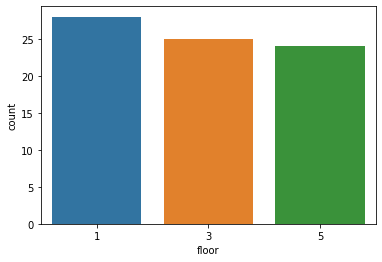

In [ ]:
sns.countplot(dataset.floor)

## sample audio

In [124]:
# sample wav for testing purposes
sampled = raw_dataset.sample(1)
SAMPLE_WAV_PATH=os.path.join("/content","Data",sampled.samples.values[0])

In [125]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=240000, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [126]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")
print_stats(waveform,sample_rate)

Sample Rate: 48000
Shape: (2, 240000)
Dtype: torch.float32
 - Max:      0.098
 - Min:     -0.101
 - Mean:    -0.000
 - Std Dev:  0.024

tensor([[ 0.0067,  0.0083,  0.0089,  ..., -0.0210, -0.0248, -0.0289],
        [ 0.0182,  0.0203,  0.0230,  ..., -0.0322, -0.0303, -0.0302]])



In [127]:
play_audio(waveform,sample_rate)
print("Etage ",sampled.floor.values[0])

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

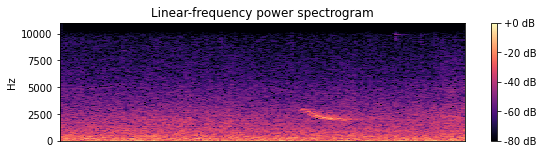

In [128]:
import librosa.display

dat2, sampling_rate2 = librosa.load(os.path.join("/content/Data",sampled.samples.values[0]))
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
D.shape

Uploading to huggingface for storage

In [139]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 6.7 MB/s 


In [140]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [142]:
!huggingface-cli lfs-enable-largefiles


usage: huggingface-cli <command> [<args>] lfs-enable-largefiles [-h] path
huggingface-cli <command> [<args>] lfs-enable-largefiles: error: the following arguments are required: path


In [144]:
from huggingface_hub import HfApi
api = HfApi()


In [146]:
# api.upload_file(
#     path_or_fileobj="building_floor_recognition_expanded_5_all.csv",
#     path_in_repo="building_floor_recognition_expanded_5_all.csv",
#     repo_id="nprime496/building_floor_classification",
#     repo_type="dataset",
# )

'https://huggingface.co/datasets/nprime496/building_floor_classification/blob/main/building_floor_recognition_expanded_5_all.csv'